# Physics-Informed Machine Learning: Learning Vector Fields from Data

## Introduction

In classical engineering, we model dynamical systems through their governing differential equations. For a damped oscillator or pendulum, we know the physics: restoring forces scale with displacement, damping forces scale with velocity, and external forces produce accelerations.

But what if we don't know all the physics? What if we have experimental data and we suspect the governing equations have an unknown form?

**Physics-Informed Machine Learning** combines two powerful ideas:
1. **Physical knowledge** — encode known physics as constraints in our learning process
2. **Machine learning** — let neural networks learn the unknown or complex parts we don't have models for

This notebook demonstrates this approach on a dissipative pendulum system. We'll see how incorporating physical structure dramatically improves learning and parameter estimation compared to purely data-driven models.

In [4]:
# download helper files
try:
  import models
except ModuleNotFoundError:
  !wget https://raw.githubusercontent.com/bentaps/physics-informed-ml-demo-blues-workshop/main/models.py -P /content/

try:
  import utils
except ModuleNotFoundError:
  !wget https://raw.githubusercontent.com/bentaps/physics-informed-ml-demo-blues-workshop/main/utils.py -P /content/




In [5]:
# %matplotlib inline
import numpy as np
import torch


# Set device random seed for reproducibility
device = torch.device("cpu")
torch.manual_seed(42)
np.random.seed(42)

## The Physical System: Pendulum with nonlinear drag

We simulate a real system described by the second-order ODE:

$$\ddot{x} = -kx - c_0\dot{x} - 0.1|\dot{x}|\dot{x}$$

where:
- **$-kx$**: Linear restoring force (spring, $k = 2.0$ N/m)
- **$-c\dot{x}$**: Linear damping (viscous resistance, $c_0 = 0.1$ N·s/m)
- **$-0.1|\dot{x}|\dot{x}$**: Nonlinear quadratic drag (e.g., from aerodynamic effects)
  
We generate synthetic data from this ODE using high-precision numerical integration (RK45 solver), then split it into training, validation, and test sets.

The data is $\{\ddot{x}(t_i),\dot{x}(t_i),x(t_i),\}_{i=1}^N$

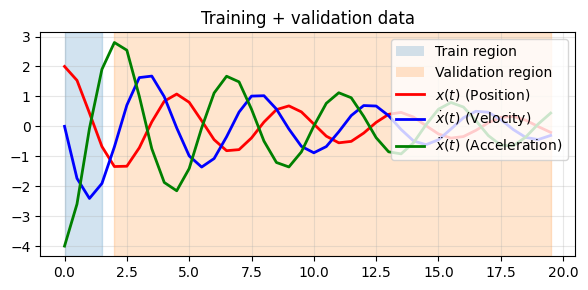

In [6]:
from utils import generate_dissipative_pendulum_data, split_and_plot_dataset

# Generate synthetic data from dissipative pendulum
k = 2.0  # Spring constant
c = 0.1  # Linear damping coefficient

def nonlinear_drag_force(v):
    return -0.1 * np.abs(v) * v

data = generate_dissipative_pendulum_data(
    spring_const=k,
    linear_drag=c,
    drag_force=nonlinear_drag_force,
    dt=0.5,
    t_span=(0, 20),
    noise_std=0.0,
)

data_train, data_val = split_and_plot_dataset(data, train_frac=0.1)

## Model 1: Vanilla Neural Network (Baseline)

**The Problem with Pure Data-Driven Learning:**

A vanilla neural network treats this as a black-box regression problem. It learns
$$\ddot{x} = f^{\theta}_{van.}(x, \dot{x})$$
by fitting a neural network $f^{\theta}_{van.}(x, \dot{x})$ to the data, but it has no awareness of the physics.

This baseline will serve as a comparison point to show how physics-informed structure improves learning.

In [7]:
from models import VanillaModel
vanilla_model = VanillaModel(hidden_dim=64).to(device)

### Training the Vanilla Model

We train on the data by minimizing the mean squared error (MSE) between predicted and true accelerations:

$$\mathcal{L}_{\text{data}} = \frac{1}{N}\sum_{i=1}^{N} \left[f^{\theta}_{van.}\left(x(t_i), \dot{x}(t_i)\right) - \ddot{x}(t_i)\right]^2$$

This purely data-driven approach learns the full nonlinear relationship without any physics constraints. Watch the training progress below.

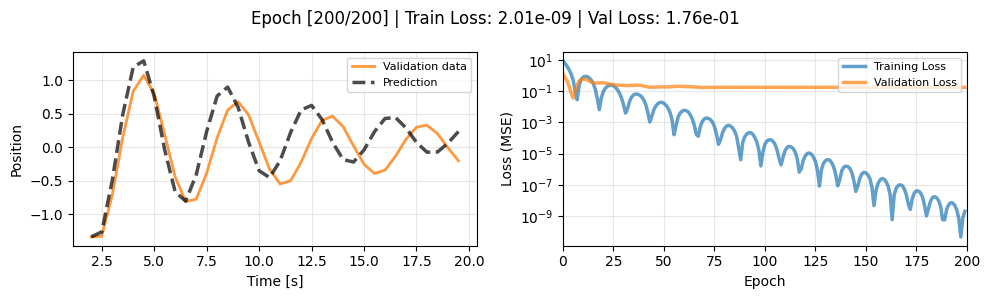


Training complete! Returning model with best validation loss: 3.631399e-02


In [8]:
from utils import train_vector_field

# Train the model with live visualization
result = train_vector_field(
    vanilla_model,
    data_train,
    data_val,
    num_epochs=200,
    print_every=10,
    lr=0.02,
)


## Model 2: Physics-Informed Neural Network (PINN)

**The Key Idea: Separating Known Physics from Unknown Physics**

Instead of treating the acceleration as a complete black box, we use our physical knowledge to decompose it:

$$\ddot{x} = f_{phys.}^{\theta}(x, \dot{x}):=\underbrace{-k^{\theta}x - c^{\theta}\dot{x}}_{\text{Known physics}} + \underbrace{F^{\theta}_{drag}(\dot{x})}_{\text{Unknown nonlinear drag}}$$

where:
- **$-k^{\theta}x$**: Linear restoring force with learnable spring constant $k^{\theta}$ (we fit it to the data)
- **$-c^{\theta}\dot{x}$**: Linear damping with learnable coefficient $c^{\theta}$ (we fit it to the data)
- **$F^{\theta}_{drag}(\dot{x})$**: Unknown nonlinear drag effects (learned by a small neural network)

**Why This Works:**
1. We reduce the complexity the neural network must learn (only the residual nonlinear part and only a function of $\dot{x}$, as opposed to both $x$ and $\dot{x}$)
2. The learnable parameters $k^{\theta}$ and $c^{\theta}$ have physical interpretations
3. We can verify if the learned values match domain knowledge

### Training the Physics-Informed Model

The loss function now includes our physical structure:

Now the optimizer learns three things: $k^{\theta}$, $c^{\theta}$, and the weights of the neural network $F^{\theta}_{drag}$.

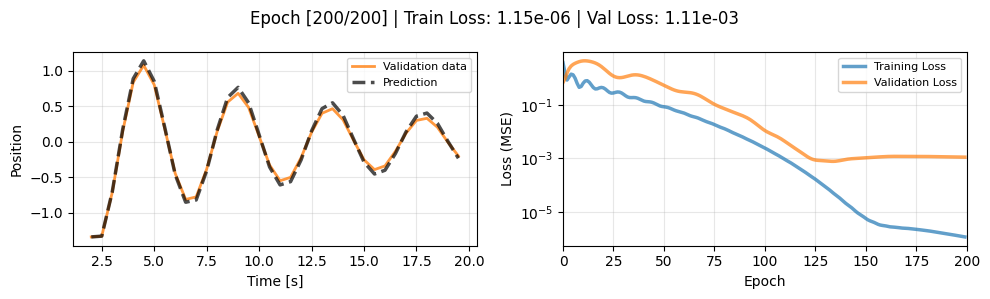


Training complete! Returning model with best validation loss: 7.747220e-04


In [9]:
from models import PhysicsInformedModel

physics_model = PhysicsInformedModel(hidden_dim=64).to(device)

# Train the model with live visualization
result = train_vector_field(
    physics_model,
    data_train,
    data_val,
    num_epochs=200,
    print_every=10,
    lr=0.02,
)


## Evaluating the models for new initial conditions
Now we test the model by integrating its learned vector field forward in time from new initial conditions (not seen during training). This tests whether the model can extrapolate beyond the training domain.

**Key Questions:** How well does a purely data-driven model generalize to new trajectories? How well does the physics-informed model generalize to new trajectories.

The incorporated physical structure should help maintain stability over longer time horizons.

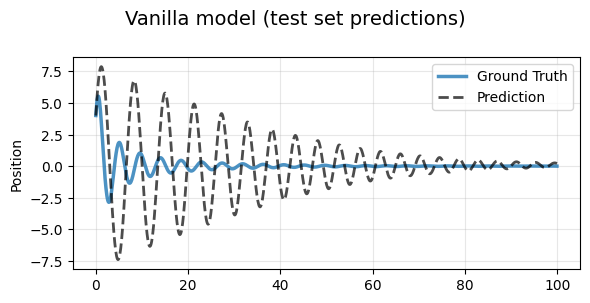

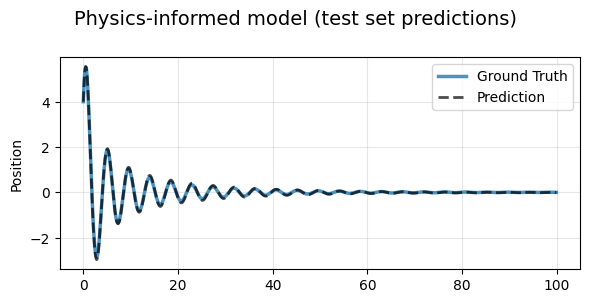

In [10]:
from utils import plot_vector_field_predictions
x0_new, v0_new = 4.0, 6.0
data_test = generate_dissipative_pendulum_data(x0=x0_new, v0=v0_new, spring_const=k, linear_drag=c, drag_force=nonlinear_drag_force)
plot_vector_field_predictions(vanilla_model, data_test, title='Vanilla model (test set predictions)')
plot_vector_field_predictions(physics_model, data_test, title='Physics-informed model (test set predictions)')

### Examine the learned physical parameters

Question: Does does the physics-informed model learn one parameter better than the other? If so, why? (Hint: is there a **unique** combination of parameters $k^{\theta}$, $c^{\theta}$ and $F_{drag}^{\theta}$ that will fit the data?)

In [11]:
print(f"Learned spring constant k: {physics_model.spring_coeff.item():.4f}")
print(f"True spring constant k: {k:.4f}")
print(f"Relative error: {abs(physics_model.spring_coeff.item() - k) / k * 100:.2f}%")

print(f"Learned linear drag coefficient c: {physics_model.linear_drag_coeff.item():.4f}")
print(f"True linear drag coefficient c: {c:.4f}")
print(f"Relative error: {abs(physics_model.linear_drag_coeff.item() - c) / c * 100:.2f}%")


Learned spring constant k: 1.9920
True spring constant k: 2.0000
Relative error: 0.40%
Learned linear drag coefficient c: 0.9526
True linear drag coefficient c: 0.1000
Relative error: 852.56%


## Summary: Physics-Informed vs. Data-Driven Learning

**Key Takeaways:**

1. **Vanilla Model**: Learned the full function $\dot{v} = f(x, v)$ with no physics constraints. It fits the training data well but may struggle with extrapolation.

2. **Physics-Informed Model**: Exploited known physics ($-Kx - C_0v$) and only learned the unknown residual ($f(v)$). This:
   - Uses fewer neural network parameters (more data-efficient)
   - Provides interpretable parameters ($K$, $C_0$ have physical meaning)
   - Generalizes better to new trajectories
   - Performs parameter estimation (inverse problem)

**When to Use Physics-Informed Learning:**
- You understand the *structure* of the physics but have unknown coefficients
- You have limited training data
- You need interpretable, verifiable parameters
- The system should conserve or obey known constraints

**The General Formula:**

$$\text{Governing equation} = \underbrace{\text{Known Physics}}_{\text{e.g., } -Kx - Cv} + \underbrace{\text{Neural Network}}_{\text{Residual/Unknown Effects}}$$

This structure can be applied to any engineered system: fluid dynamics, structural mechanics, control systems, and more.

## Further Exploration

**Try modifying the code above to explore:**
- Change the spring constant `k` or damping `c0` — how sensitive are the learned parameters?
- Increase training data — does the vanilla model improve relative to the physics-informed one?
- Add noise to the training data — does physics-informed structure make learning more robust?
- Modify the drag force, see if the physics informed model can still learn it well.
